In [677]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import pandas as pd
import numpy as np

In [678]:
spark = SparkSession.builder.appName('ga').getOrCreate()

### load data of selected days

In [679]:
from os import listdir
from os.path import isfile, join

directory = '/Users/ing/Documents/google analysis/data/'
fileList = os.listdir(directory)
fileList = [f for f in fileList if 'json' in f]
fileList

['ga_sessions_20160802.json',
 'ga_sessions_20160803.json',
 'ga_sessions_20160804.json',
 'ga_sessions_20160805.json',
 'ga_sessions_20160806.json',
 'ga_sessions_20160807.json',
 'ga_sessions_20160801.json']

In [680]:
startDate = '20160801'
stopDate = '20160803'

selectedDate = [f for f in fileList if (f >= 'ga_sessions_'+startDate+'.json' and f <= 'ga_sessions_'+stopDate+'.json')]
selectedDatepaths = [directory + f for f in selectedDate]

# "dir1/,dir2/,dir3/*"

df = spark.read.format('json') \
  .option("inferSchema", True) \
  .option("maxColumns", "540000") \
  .option("header", True) \
  .option("sep", "\t") \
  .load(selectedDatepaths)

In [681]:
df.toPandas().head()

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,userId,visitId,visitNumber,visitStartTime,visitorId
0,Organic Search,"[(4, APAC)]",20160802,"(Safari, not available in demo dataset, not av...",9932908116119920975,"(Melbourne, not available in demo dataset, Oce...","[((None, None, None, None, shop.googlemerchand...",Not Socially Engaged,"(1, 1, None, 1, None, None, None, None, None, ...","(None, (None, None, None, None, None, not avai...",None,1470191844,5,1470191844,None
1,Direct,[],20160802,"(Chrome, not available in demo dataset, not av...",5320937337095104430,"(not available in demo dataset, not available ...","[((None, None, None, None, shop.googlemerchand...",Not Socially Engaged,"(1, 1, None, 1, None, None, None, None, None, ...","(None, (None, None, None, None, None, not avai...",None,1470127145,2,1470127145,None
2,Organic Search,"[(4, EMEA)]",20160802,"(Chrome, not available in demo dataset, not av...",2314762785260651364,"(not available in demo dataset, not available ...","[((None, None, None, None, shop.googlemerchand...",Not Socially Engaged,"(1, 1, 1, 1, None, None, None, None, None, Non...","(None, (None, None, None, None, None, not avai...",None,1470176183,1,1470176183,None
3,Direct,"[(4, North America)]",20160802,"(Chrome, not available in demo dataset, not av...",1144912080450618887,"(San Bruno, not available in demo dataset, Ame...","[((None, None, None, None, shop.googlemerchand...",Not Socially Engaged,"(1, 1, 1, 1, None, None, None, None, None, Non...","(None, (None, None, None, None, None, not avai...",None,1470169596,1,1470169596,None
4,Direct,"[(4, North America)]",20160802,"(Chrome, not available in demo dataset, not av...",1408951569184570430,"(San Bruno, not available in demo dataset, Ame...","[((None, None, None, None, shop.googlemerchand...",Not Socially Engaged,"(1, 1, 1, 1, None, None, None, None, None, Non...","(None, (None, None, None, None, None, not avai...",None,1470180889,1,1470180889,None


In [682]:
df.count()

6741

## count visitor number

### timestamp converting

In [683]:
import time
from datetime import datetime
import pytz

def visitStartTimeConvert(x):
    t = datetime.fromtimestamp(x["visitStartTime"], pytz.timezone("US/Pacific"))
    
    return (x['fullVisitorId'], t.strftime("%Y%m%d%H%M%S"))

visitStartTimeConverted = df.rdd.map(visitStartTimeConvert)
visitStartTimeConverted.take(5)

[('9932908116119920975', '20160802193724'),
 ('5320937337095104430', '20160802013905'),
 ('2314762785260651364', '20160802151623'),
 ('1144912080450618887', '20160802132636'),
 ('1408951569184570430', '20160802163449')]

### visits per hour

In [684]:
def groupByHour(x):
    return (x[0], x[1][:10])

visitGroupByHour = visitStartTimeConverted.map(groupByHour)
visitHour = visitGroupByHour.map(lambda x: (x[1], 1))

visitHour = visitHour.reduceByKey(lambda x, y: x + y)
visitHour = visitHour.sortByKey(ascending=True)
visitHour.take(5)

[('2016080100', 38),
 ('2016080101', 42),
 ('2016080102', 51),
 ('2016080103', 43),
 ('2016080104', 41)]

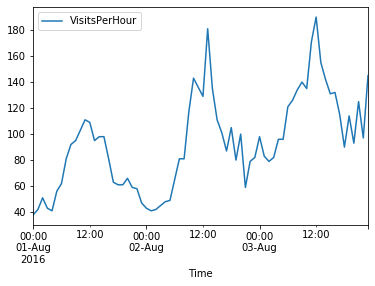

In [685]:
import matplotlib.pyplot as plt

visitHourPd = visitHour.toDF().toPandas()
visitHourPd.columns = ['Time','VisitsPerHour']
visitHourPd['Time'] = pd.to_datetime(visitHourPd['Time'], format='%Y%m%d%H', errors='coerce')

visitHourPd.plot(x ='Time', y='VisitsPerHour', kind = 'line')
plt.show()

In [686]:
csv_name_vh = 'visitsPerHour' + startDate + 'to' + stopDate + '.csv'
visitHourPd.to_csv(csv_name_h)

### visitors per hour

In [687]:
visitorHour = visitGroupByHour.distinct().map(lambda x: (x[1], 1))

visitorHour = visitorHour.reduceByKey(lambda x, y: x + y)
visitorHour = visitorHour.sortByKey(ascending=True)
visitorHour.take(5)

[('2016080100', 38),
 ('2016080101', 41),
 ('2016080102', 51),
 ('2016080103', 43),
 ('2016080104', 40)]

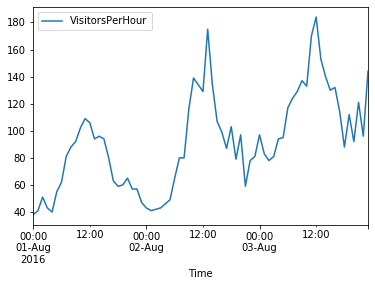

In [688]:

visitorHourPd = visitorHour.toDF().toPandas()
visitorHourPd.columns = ['Time','VisitorsPerHour']
visitorHourPd['Time'] = pd.to_datetime(visitorHourPd['Time'], format='%Y%m%d%H', errors='coerce')

visitorHourPd.plot(x ='Time', y='VisitorsPerHour', kind = 'line')
plt.show()

In [689]:
csv_name_h = 'visitorsPerHour' + startDate + 'to' + stopDate + '.csv'
visitorHourPd.to_csv(csv_name_h)

### visits per minute

In [690]:
def groupByMin(x):
    return (x[0], x[1][:12])

visitGroupByMin = visitStartTimeConverted.map(groupByMin)
visitMin = visitGroupByMin.map(lambda x: (x[1], 1))

visitMin = visitMin.reduceByKey(lambda x, y: x + y)
visitMin = visitMin.sortByKey(ascending=True)
visitMin.take(5)

[('201608010000', 1),
 ('201608010004', 2),
 ('201608010006', 2),
 ('201608010008', 1),
 ('201608010010', 2)]

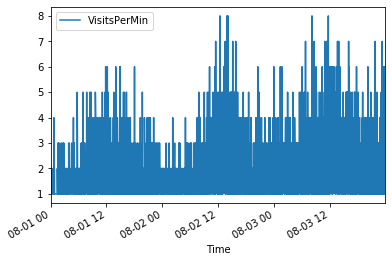

In [691]:
visitMinPd = visitMin.toDF().toPandas()
visitMinPd.columns = ['Time','VisitsPerMin']
visitMinPd['Time'] = pd.to_datetime(visitMinPd['Time'], format='%Y%m%d%H%M', errors='coerce')

visitMinPd.plot(x ='Time', y='VisitsPerMin', kind = 'line')
plt.show()

In [692]:
csv_name_vm = 'visitsPerMin' + startDate + 'to' + stopDate + '.csv'
visitMinPd.to_csv(csv_name_h)

### visitors per minute

In [693]:
visitorMin = visitGroupByMin.distinct().map(lambda x: (x[1], 1))
visitorMin = visitorMin.reduceByKey(lambda x, y: x + y)
visitorMin = visitorMin.sortByKey(ascending=True)
visitorMin.take(5)

[('201608010000', 1),
 ('201608010004', 2),
 ('201608010006', 2),
 ('201608010008', 1),
 ('201608010010', 2)]

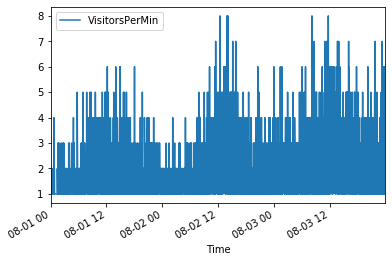

In [694]:
visitorMinPd = visitorMin.toDF().toPandas()
visitorMinPd.columns = ['Time','VisitorsPerMin']
visitorMinPd['Time'] = pd.to_datetime(visitorMinPd['Time'], format='%Y%m%d%H%M', errors='coerce')

visitorMinPd.plot(x ='Time', y='VisitorsPerMin', kind = 'line')
plt.show()

In [695]:
csv_name_m = 'visitorsPerMin' + startDate + 'to' + stopDate + '.csv'
visitorMinPd.to_csv(csv_name_h)

### visit pattern

In [696]:
def groupByHourOnly(x):
    return (x[0][-2:], x[1])

# x[0]: hour x[1]: visit num
visitPatternHour = visitHour.map(groupByHourOnly)
visitPatternHour = visitPatternHour.reduceByKey(lambda x, y: x + y)
visitPatternHour = visitPatternHour.sortByKey(ascending=True)
visitPatternHour.take(24)

[('00', 179),
 ('01', 166),
 ('02', 172),
 ('03', 170),
 ('04', 185),
 ('05', 201),
 ('06', 248),
 ('07', 288),
 ('08', 307),
 ('09', 352),
 ('10', 381),
 ('11', 418),
 ('12', 428),
 ('13', 431),
 ('14', 375),
 ('15', 340),
 ('16', 314),
 ('17', 265),
 ('18', 256),
 ('19', 255),
 ('20', 259),
 ('21', 243),
 ('22', 234),
 ('23', 274)]

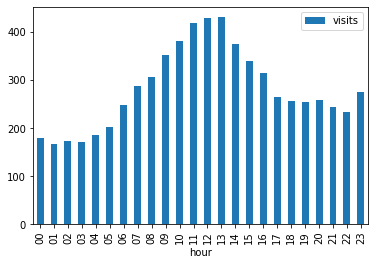

In [697]:
visitPatternHourPd = visitPatternHour.toDF().toPandas()
visitPatternHourPd.columns = ['hour', 'visits']
visitPatternHourPd.plot(x ='hour', y='visits', kind = 'bar')
plt.show()

In [698]:
csv_name_vp = 'visitsPattern' + startDate + 'to' + stopDate + '.csv'
visitPatternHourPd.to_csv(csv_name_vp)

## popular device

In [699]:
def deviceExtract(x):
    t = datetime.fromtimestamp(x["visitStartTime"], pytz.timezone("US/Pacific"))
    return (t.strftime("%Y%m%d%H%M%S"), [x['device'].browser, x['device'].deviceCategory, x['device'].isMobile, x['device'].operatingSystem])
deviceExtracted = df.rdd.map(deviceExtract)
deviceExtracted.take(5)
#0- browser, 1- deviceCategory, 2- isMobile, 3- operatingSystem

[('20160802193724', ['Safari', 'mobile', True, 'iOS']),
 ('20160802013905', ['Chrome', 'mobile', True, 'Android']),
 ('20160802151623', ['Chrome', 'mobile', True, 'Android']),
 ('20160802132636', ['Chrome', 'desktop', False, 'Macintosh']),
 ('20160802163449', ['Chrome', 'desktop', False, 'Windows'])]

### operating system

In [700]:
visitGroupByOS = deviceExtracted.map(lambda x: (x[0], x[1][3]))
## delete min in timestamp
visitGroupByOSH = visitGroupByOS.map(lambda x:(x[0][:10], x[1]))
visitGroupByOSH = visitGroupByOSH.map(lambda x: ((x[0],x[1]), 1))
visitGroupByOSH = visitGroupByOSH.reduceByKey(lambda x, y: x + y)
visitGroupByOSH = visitGroupByOSH.sortByKey(ascending=True)
visitGroupByOSH = visitGroupByOSH.map(lambda x: (x[0][0], x[0][1], x[1]))

visitGroupByOSH.take(5)

[('2016080100', 'Android', 5),
 ('2016080100', 'Linux', 1),
 ('2016080100', 'Macintosh', 10),
 ('2016080100', 'Windows', 15),
 ('2016080100', 'iOS', 7)]

In [701]:
visitGroupByOSHPd = visitGroupByOSH.toDF().toPandas()
visitGroupByOSHPd.columns = ['time', 'OS', 'num']
visitGroupByOSHPd['time'] = pd.to_datetime(visitGroupByOSHPd['time'], format='%Y%m%d%H', errors='coerce')
visitGroupByOSHPd

,time,OS,num
0,2016-08-01 00:00:00,Android,5
1,2016-08-01 00:00:00,Linux,1
2,2016-08-01 00:00:00,Macintosh,10
3,2016-08-01 00:00:00,Windows,15
4,2016-08-01 00:00:00,iOS,7
...,...,...,...
440,2016-08-03 23:00:00,Firefox OS,1
441,2016-08-03 23:00:00,Linux,1
442,2016-08-03 23:00:00,Macintosh,40
443,2016-08-03 23:00:00,Windows,79


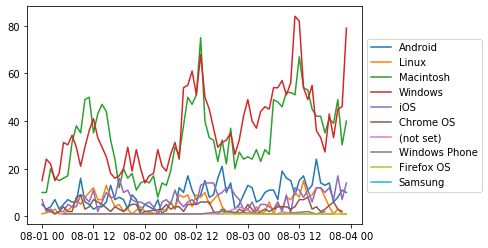

In [702]:
OSList = visitGroupByOSHPd['OS'].unique()
for o in OSList:
    n = visitGroupByOSHPd[visitGroupByOSHPd['OS'] == o]
    plt.plot('time','num',data=n, label = o)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


### browser

In [703]:
visitGroupByBrowser = deviceExtracted.map(lambda x: (x[0], x[1][0]))
## delete min in timestamp
visitGroupByBrowserH = visitGroupByBrowser.map(lambda x:(x[0][:10], x[1]))
visitGroupByBrowserH = visitGroupByBrowserH.map(lambda x: ((x[0],x[1]), 1))
visitGroupByBrowserH = visitGroupByBrowserH.reduceByKey(lambda x, y: x + y)
visitGroupByBrowserH = visitGroupByBrowserH.sortByKey(ascending=True)
visitGroupByBrowserH = visitGroupByBrowserH.map(lambda x: (x[0][0], x[0][1], x[1]))
visitGroupByBrowserH.take(5)

[('2016080100', 'Amazon Silk', 1),
 ('2016080100', 'Chrome', 24),
 ('2016080100', 'Safari', 13),
 ('2016080101', 'Chrome', 27),
 ('2016080101', 'Firefox', 4)]

In [704]:
visitGroupByBrowserHPd = visitGroupByBrowserH.toDF().toPandas()
visitGroupByBrowserHPd.columns = ['time', 'browser', 'num']
visitGroupByBrowserHPd['time'] = pd.to_datetime(visitGroupByBrowserHPd['time'], format='%Y%m%d%H', errors='coerce')
visitGroupByBrowserHPd

,time,browser,num
0,2016-08-01 00:00:00,Amazon Silk,1
1,2016-08-01 00:00:00,Chrome,24
2,2016-08-01 00:00:00,Safari,13
3,2016-08-01 01:00:00,Chrome,27
4,2016-08-01 01:00:00,Firefox,4
...,...,...,...
408,2016-08-03 23:00:00,Chrome,103
409,2016-08-03 23:00:00,Firefox,8
410,2016-08-03 23:00:00,Opera Mini,2
411,2016-08-03 23:00:00,Safari,31


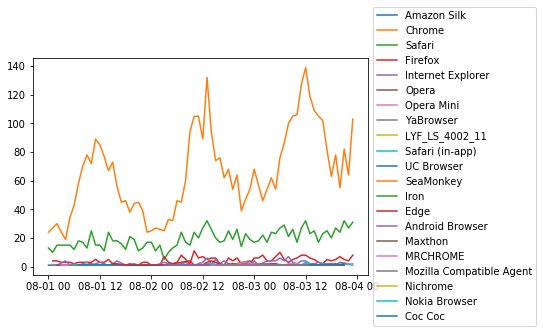

In [705]:
browserList = visitGroupByBrowserHPd['browser'].unique()
for b in browserList:
    n = visitGroupByBrowserHPd[visitGroupByBrowserHPd['browser'] == b]
    plt.plot('time','num',data=n, label = b)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


## location

In [706]:
def countryExtract(x):
    t = datetime.fromtimestamp(x["visitStartTime"], pytz.timezone("US/Pacific"))
    return (t.strftime("%Y%m%d"), x['geoNetwork'].country)
country = df.rdd.map(countryExtract)
country = country.map(lambda x: ((x[0],x[1]), 1))
country = country.reduceByKey(lambda x, y: x + y)
country = country.map(lambda x: (x[0][0], x[0][1], x[1]))

country.take(5)


[('20160802', 'Taiwan', 12),
 ('20160802', 'Indonesia', 30),
 ('20160802', 'Italy', 19),
 ('20160802', 'Chile', 3),
 ('20160802', 'Malaysia', 12)]

In [707]:
countryPd = country.toDF().toPandas()
countryPd.columns = ['date', 'country', 'num']
countryPd['date'] = pd.to_datetime(countryPd['date'], format='%Y%m%d', errors='coerce')

countryPd

,date,country,num
0,2016-08-02,Taiwan,12
1,2016-08-02,Indonesia,30
2,2016-08-02,Italy,19
3,2016-08-02,Chile,3
4,2016-08-02,Malaysia,12
...,...,...,...
294,2016-08-01,Bosnia & Herzegovina,4
295,2016-08-01,Serbia,3
296,2016-08-01,Mongolia,2
297,2016-08-01,Oman,2


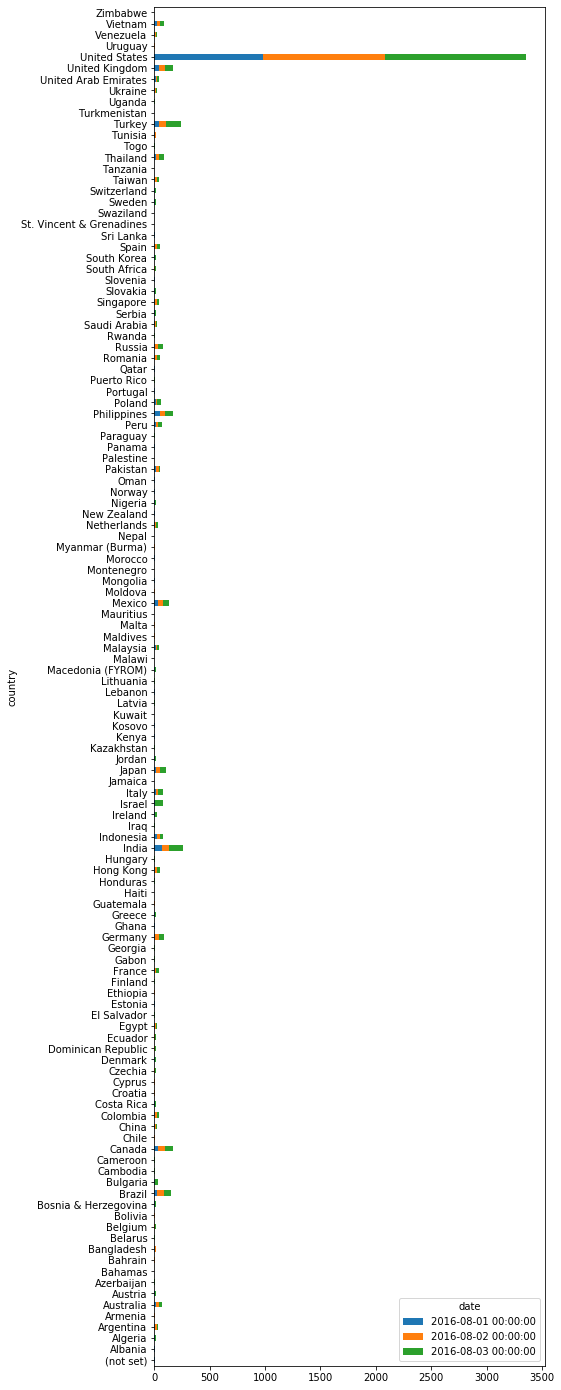

In [708]:
pivot_countryPd = countryPd.pivot(index='country', columns='date', values='num')
pivot_countryPd.plot.barh(stacked=True, figsize=(7,25))
plt.show()

## average visit duration

In [709]:
def hitTimeExtract(x):
    t = datetime.fromtimestamp(x["visitStartTime"], pytz.timezone("US/Pacific"))
    return (t.strftime("%Y%m%d%H"), (x['hits'][-1].time, 1))
duration = df.rdd.map(hitTimeExtract).filter(lambda x: x[1][0] != 0)
duration = duration.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1])) \
                    .map(lambda x: (x[0], x[1][0]/1000/x[1][1]))

duration.take(5)

[('2016080223', 158.78373684210527),
 ('2016080212', 411.8829701492537),
 ('2016080207', 301.85340909090905),
 ('2016080216', 204.96395161290323),
 ('2016080221', 259.59845454545456)]

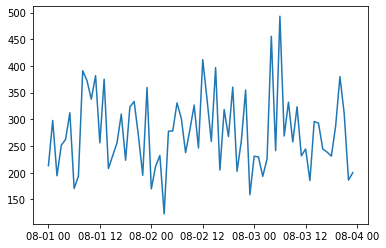

In [710]:
durationPd = duration.toDF().toPandas()
durationPd.columns = ['time', 'duration']
durationPd['time'] = pd.to_datetime(durationPd['time'], format='%Y%m%d%H', errors='coerce')
durationPd = durationPd.sort_values('time')
plt.plot('time','duration',data=durationPd,)
plt.show()

### most visited page

In [711]:
# extract all the visited pages
def hitPageExtract(x):
    t = datetime.fromtimestamp(x["visitStartTime"], pytz.timezone("US/Pacific"))
    return (t.strftime("%Y%m%d%H"), (x['hits']))
hitPage = df.rdd.map(hitPageExtract)
hitPage = hitPage.flatMap(lambda x: [(x[0], h.page.pagePath) for h in x[1]])
hitPage.take(5)

[('2016080219', '/signin.html'),
 ('2016080201', '/google+redesign/shop+by+brand/google'),
 ('2016080215', '/google+redesign/apparel/men++s/men++s+bike+gear'),
 ('2016080213',
  '/google+redesign/office/notebooks+journals/youtube+leatherette+notebook+combo.axd'),
 ('2016080216',
  '/google+redesign/apparel/kids/kids+infant/google+baby+essentials+set+white.axd')]

In [712]:
# page count grouped by day
hitPage = hitPage.map(lambda x: ((x[0][:-2], x[1]), 1)) \
            .reduceByKey(lambda x, y: x + y)
hitPage = hitPage.map(lambda x: (x[0][0], x[0][1], x[1]))
hitPage.take(5)

[('20160802', '/google+redesign/electronics', 660),
 ('20160802', '/google+redesign/apparel/women+s', 164),
 ('20160802', '/google+redesign/lifestyle/fun', 23),
 ('20160802', '/google+redesign/apparel/kid+s/kid+s+infant', 111),
 ('20160802', '/google+redesign/apparel', 230)]

In [713]:
hitPagePd = hitPage.toDF().toPandas()
hitPagePd.columns = ['date', 'pagePath', 'count']
hitPagePd['date'] = pd.to_datetime(hitPagePd['date'], format='%Y%m%d', errors='coerce')
dateList = hitPagePd['date'].unique()
dateList = np.sort(dateList)
pageDailyRank = pd.DataFrame()

for d in dateList:
    df = hitPagePd[hitPagePd['date'] == d]
    df = df.sort_values(by='count', ascending=False)
    df = df[:10].reset_index(drop=True)
    df['rank'] = rank
    pageDailyRank = pageDailyRank.append(df)

pageDailyRank

,date,pagePath,count,rank
0,2016-08-01,/home,2238,1
1,2016-08-01,/google+redesign/lifestyle,697,2
2,2016-08-01,/google+redesign/office,688,3
3,2016-08-01,/basket.html,684,4
4,2016-08-01,/google+redesign/apparel/men++s/men++s+t+shirts,667,5
5,2016-08-01,/google+redesign/electronics,627,6
6,2016-08-01,/google+redesign/drinkware,604,7
7,2016-08-01,/google+redesign/bags,578,8
8,2016-08-01,/store.html,445,9
9,2016-08-01,/google+redesign/apparel/women+s/women+s+t+shirts,420,10
